In [1]:
import numpy as np
import h5py 
import os
# plotting
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'font.size': 30,
    'legend.fontsize': 10,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': True,
    'font.family': 'serif',
}
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
def equalize(ax):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

In [3]:
colors = [
    '#377eb8', '#ff7f00', '#4daf4a', 
    '#f781bf', '#a65628', '#984ea3', 
    '#999999', '#e41a1c', '#dede00',
    '#595959', '#5F9ED1', '#C85200',
    '#A2C8EC', '#FFBC79', '#000000'
]

In [4]:
base_exp4 = 'results/exp4'
base_exp5 = 'results/exp5'
sparsities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
correlations = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
Ls = np.array([0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
exp4 = {}
exp5 = {}
for sparsity in sparsities:
    exp4[sparsity] = h5py.File(os.path.join(base_exp4, 'exp4_uoicorr%0.1f.h5' %sparsity), 'r')
    exp5[sparsity] = h5py.File(os.path.join(base_exp5, 'exp5_uoicorr%0.1f.h5' %sparsity), 'r')

In [5]:
n_features = 50
n_reps = 100
n_sparsities = sparsities.size
n_Ls = Ls.size

In [89]:
int(n_features - n_features * 0.8)

10

In [87]:
50 * (1 - 0.8)

9.999999999999998

# ROC 

In [92]:
def calculate_fp_fn(avg=True):
    fpr_uoi = np.zeros((sparsities.size, Ls.size, n_reps))
    fnr_uoi = np.zeros((sparsities.size, Ls.size, n_reps))
    fpr_enet = np.zeros((sparsities.size, Ls.size, n_reps))
    fnr_enet = np.zeros((sparsities.size, Ls.size, n_reps))
    for sparsity_idx, sparsity in enumerate(sparsities[:-1]):
        file = exp4[sparsity]
        betas = file['betas']
        uoi_results = file['beta_hats_uoi']
        enet_results = file['beta_hats_enet']
        max_fp = int(n_features - n_features * sparsity)
        max_fn = int(n_features * sparsity)
        for rep in range(n_reps):
            beta_true = betas[rep]
            for L_idx, L in enumerate(Ls):
                beta_hat_uoi = uoi_results[rep, L_idx, :]
                beta_hat_enet = enet_results[rep, L_idx, :]
                fpr_uoi[sparsity_idx, L_idx, rep] = np.count_nonzero(beta_hat_uoi[beta_true == 0])/max_fp
                fpr_enet[sparsity_idx, L_idx, rep] = np.count_nonzero(beta_hat_enet[beta_true == 0])/max_fp
                fnr_uoi[sparsity_idx, L_idx, rep] = np.count_nonzero(beta_true[beta_hat_uoi == 0])/max_fn
                fnr_enet[sparsity_idx, L_idx, rep] = np.count_nonzero(beta_true[beta_hat_enet == 0])/max_fn
    if avg:
        return np.mean(fpr_uoi, axis=2), np.mean(fnr_uoi, axis=2), np.mean(fpr_enet, axis=2), np.mean(fnr_enet, axis=2)
    else:
        return fpr_uoi, fnr_uoi, fpr_enet, fnr_enet

In [93]:
def plot_fp_fn():
    fpr_uoi, fnr_uoi, fpr_enet, fnr_enet = calculate_fp_fn()
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    uoi = axes[0]
    enet = axes[1]
    
    for L_idx, L in enumerate(Ls):
        uoi.plot(fnr_uoi[:-1, L_idx], fpr_uoi[:-1, L_idx], color=colors[L_idx], linewidth=3, marker='o', markersize=10)
        enet.plot(fnr_enet[:-1, L_idx], fpr_enet[:-1, L_idx], color=colors[L_idx], linewidth=3, marker='o', markersize=10)
    
    for ax in axes:
        ax.set_xlabel('fnr')
        ax.set_ylabel('fpr')
    return fig, axes

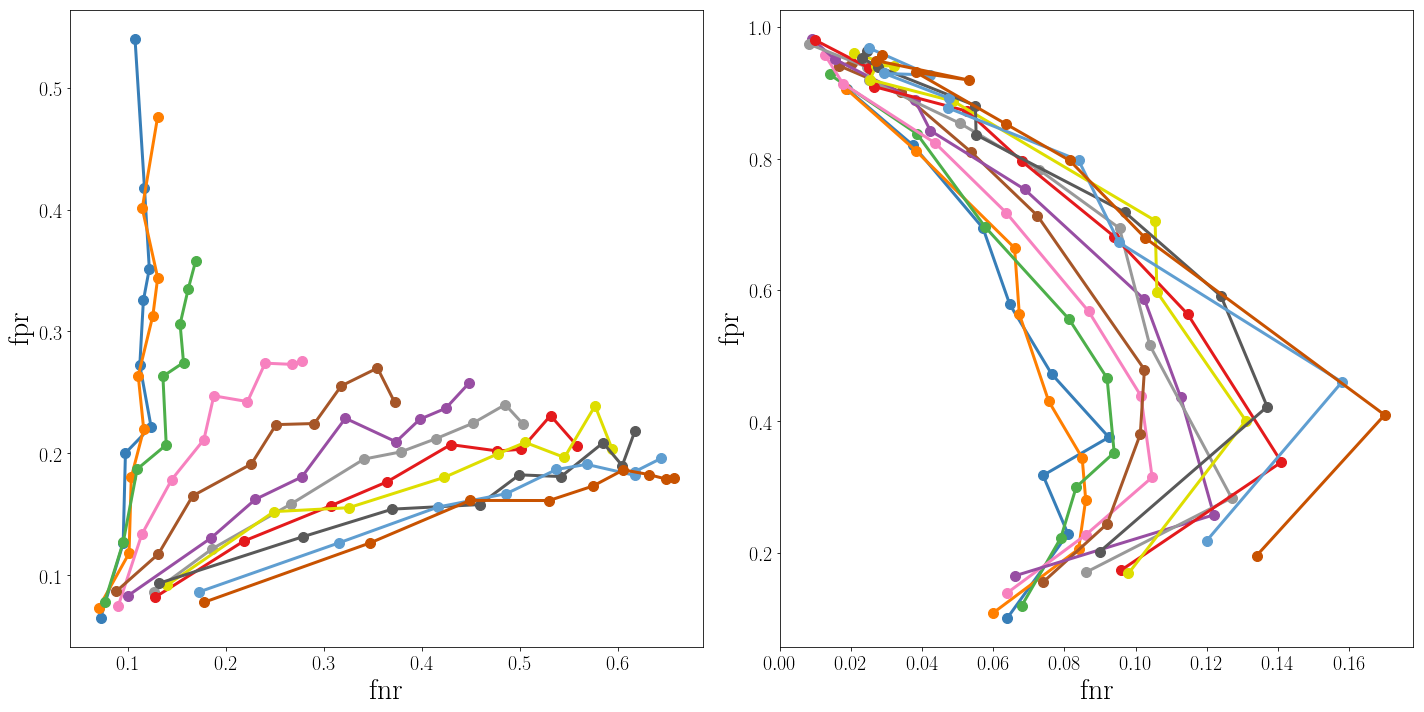

In [94]:
fig, axes = plot_fp_fn()
plt.tight_layout()

In [53]:
np.mean(exp4[0.5]['r2_true'], axis=0)

array([0.77171035, 0.76590182, 0.76788115, 0.76915449, 0.77283727,
       0.7669083 , 0.76871395, 0.77020479, 0.76848556, 0.76269439,
       0.76930603, 0.76764031])